In [1]:
import numpy as np
import tables, pylab, sys, operator,dashi, os
import glob
import matplotlib.pyplot as plt
from icecube import NewNuFlux, dataclasses,astro
plt.rcParams['figure.figsize'] = (8.5,6.5)
plt.rc('font',size = 14)

RuntimeError: FATAL: module compiled as little endian, but detected different endianness at runtime

In [2]:
Data_postcut_2 = np.load('Data_post_cut_gamma_2.0.npy')
MC_postcut_2 = np.load('MC_post_cut_gamma_2.0.npy')

In [3]:
# 2d array for features
Features = np.zeros((len(MC_postcut_2)+len(Data_postcut_2),10))

Features.T[0][:] = np.concatenate((MC_postcut_2['spMPE_ldirE'],Data_postcut_2['spMPE_ldirE']))
Features.T[1][:] = np.concatenate((MC_postcut_2['spMPE_ndirE'],Data_postcut_2['spMPE_ndirE']))
Features.T[2][:] = np.concatenate((MC_postcut_2['spMPE_rlogl'],Data_postcut_2['spMPE_rlogl']))
Features.T[3][:] = np.concatenate((MC_postcut_2['spMPE_parabo'],Data_postcut_2['spMPE_parabo']))
Features.T[4][:] = np.concatenate((MC_postcut_2['LineFit_delta_angle'],Data_postcut_2['LineFit_delta_angle']))
Features.T[5][:] = np.concatenate((MC_postcut_2['MPEHighNoise_delta_angle'],Data_postcut_2['MPEHighNoise_delta_angle']))
Features.T[6][:] = np.concatenate((MC_postcut_2['SplitMinZenith'],Data_postcut_2['SplitMinZenith']))
Features.T[7][:] = np.concatenate((MC_postcut_2['BayesLLHRatio'],Data_postcut_2['BayesLLHRatio']))
Features.T[8][:] = np.concatenate((MC_postcut_2['cog_z'],Data_postcut_2['cog_z']))
Features.T[9][:] = np.concatenate((MC_postcut_2['cog_r2'],Data_postcut_2['cog_r2']))

In [4]:
Event_Type = np.concatenate((np.ones(len(MC_postcut_2)), np.zeros(len(Data_postcut_2))))

In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve



In [6]:
X_train, X_test, y_train, y_test = train_test_split(Features, Event_Type, test_size = 0.25)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Features, Event_Type, test_size = 0.25)

dt = DecisionTreeClassifier(max_depth = 1)

#ada boost classifier 
    
adb_clf = AdaBoostClassifier(base_estimator = dt, n_estimators = 100)

    #fit to training set
adb_clf.fit(X_train,y_train)

    #predict
#y_pred = adb_clf.predict(X_test)
y_prob = adb_clf.predict_proba(X_test)[:, 1]

    #calc mse
#acc = accuracy_score(y_test, y_pred)



(0.2, 1.02)

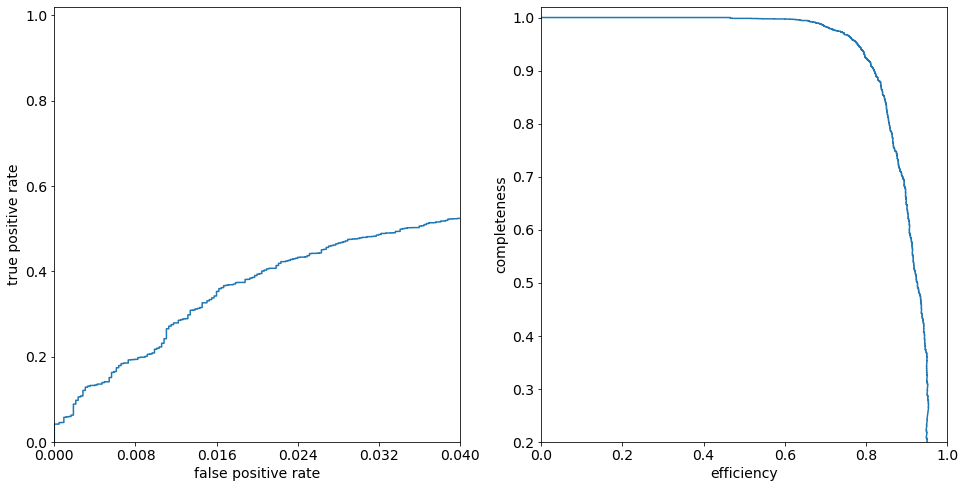

In [8]:

fig, ax = plt.subplots(figsize=(16, 8))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

thresholds = np.linspace(0, 1, 1001)[:-1]

fpr, tpr, thresh = roc_curve(y_test, y_prob)
precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    # add (0, 0) as first point
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
precision = np.concatenate([[0], precision])
recall = np.concatenate([[1], recall])
thresh2 = np.concatenate([[0], thresh2])

ax1.plot(fpr, tpr)
comp = np.zeros_like(thresholds)
cont = np.zeros_like(thresholds)
#for i, t in enumerate(thresholds):
#    y_pred = (y_pred >= t)
#    comp[i], cont[i] = completeness_contamination(y_pred, y_test)
#ax2.plot(1 - cont, comp)
ax2.plot(precision, recall)
ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
#ax1.legend(loc=4)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0.2, 1.02)


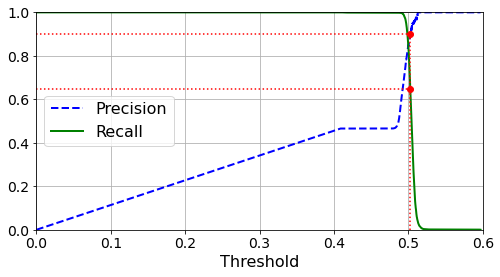

In [9]:
#Uses the values of precisions, recalls, and thresholds from above
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)                
    plt.axis([0, 0.6, 0, 1])             

recall_90_precision = recall[np.argmax(precision >= 0.90)]
threshold_90_precision = thresh2[np.argmax(precision >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precision, recall, thresh2)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([0, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([0, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
#save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

In [ ]:
#festure importance
#voting classifier （soft
#xgboost

In [10]:
LT_day = 0
for run in np.unique(Data_postcut_2['run']):
    mask = (Data_postcut_2['run'] == run)
    min_time = np.min(Data_postcut_2[mask]['time'])
    max_time = np.max(Data_postcut_2[mask]['time'])
    run_time = max_time - min_time
    print(run_time)
    LT_day += run_time
    
LT = LT_day*86400

print(LT)

#gamma = 2.7
#livetime = good_run_list.sum()[0]
fluxNorm = 1.0e-18
mcWeights_27 = fluxNorm * MC_postcut_2['ow'] * (MC_postcut_2['trueE']/1.0e5)**(-2.7) * LT
mcWeights_20 = fluxNorm * MC_postcut_2['ow'] * (MC_postcut_2['trueE']/1.0e5)**(-2.0) * LT

0.3320981991637382
0.3333229320196551
0.3333709106882452
86295.63241770957


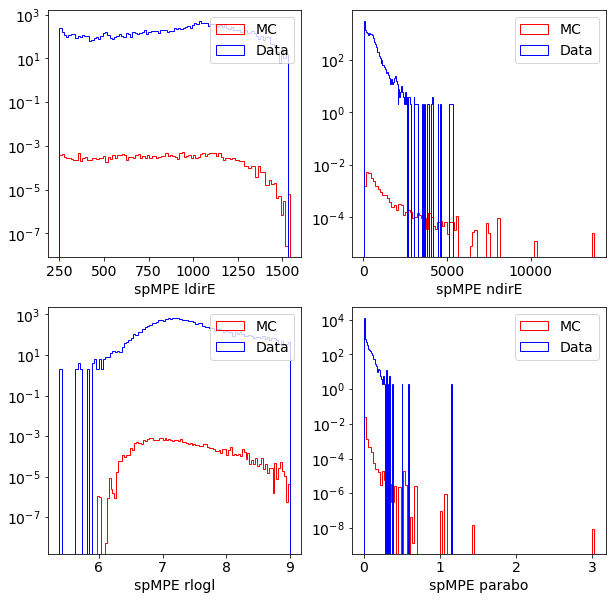

In [11]:
mask0 = y_test ==0
mask1 = y_test ==1
fig, ax = plt.subplots(figsize=(10, 10))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)




MC_X = MC_postcut_2['spMPE_ldirE']
Data_X = Data_postcut_2['spMPE_ldirE']
ax1.hist(MC_X, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax1.hist(Data_X, bins = 100, histtype='step', color = 'b', label = 'Data');
ax1.set_yscale('log')
ax1.set_xlabel('spMPE ldirE')
ax1.legend()

MC_X = MC_postcut_2['spMPE_ndirE']
Data_X = Data_postcut_2['spMPE_ndirE']
ax2.hist(MC_X, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax2.hist(Data_X, bins = 100, histtype='step', color = 'b', label = 'Data');
ax2.set_yscale('log')
ax2.set_xlabel('spMPE ndirE')
ax2.legend()

MC_X = MC_postcut_2['spMPE_rlogl']
Data_X = Data_postcut_2['spMPE_rlogl']
ax3.hist(MC_X, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax3.hist(Data_X, bins = 100, histtype='step', color = 'b', label = 'Data');
ax3.set_yscale('log')
ax3.set_xlabel('spMPE rlogl')
ax3.legend()

MC_X = MC_postcut_2['spMPE_parabo']
Data_X = Data_postcut_2['spMPE_parabo']
ax4.hist(MC_X, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax4.hist(Data_X, bins = 100, histtype='step', color = 'b', label = 'Data');
ax4.set_yscale('log')
ax4.set_xlabel('spMPE parabo')
ax4.legend()
#plt.savefig('Plots/BDT_feat1.png')

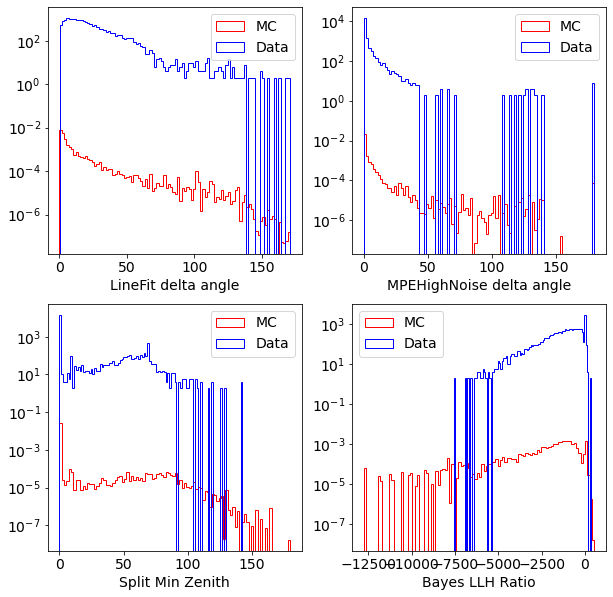

In [12]:

fig, ax = plt.subplots(figsize=(10, 10))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)




MC_X = MC_postcut_2['LineFit_delta_angle']
Data_X = Data_postcut_2['LineFit_delta_angle']
ax1.hist(MC_X, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax1.hist(Data_X, bins = 100, histtype='step', color = 'b', label = 'Data');
ax1.set_yscale('log')
ax1.set_xlabel('LineFit delta angle')
ax1.legend()

MC_X = MC_postcut_2['MPEHighNoise_delta_angle']
Data_X = Data_postcut_2['MPEHighNoise_delta_angle']
ax2.hist(MC_X, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax2.hist(Data_X, bins = 100, histtype='step', color = 'b', label = 'Data');
ax2.set_yscale('log')
ax2.set_xlabel('MPEHighNoise delta angle')
ax2.legend()

MC_X = MC_postcut_2['SplitMinZenith']
Data_X = Data_postcut_2['SplitMinZenith']
ax3.hist(MC_X, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax3.hist(Data_X, bins = 100, histtype='step', color = 'b', label = 'Data');
ax3.set_yscale('log')
ax3.set_xlabel('Split Min Zenith')
ax3.legend()

MC_X = MC_postcut_2['BayesLLHRatio']
Data_X = Data_postcut_2['BayesLLHRatio']
ax4.hist(MC_X, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax4.hist(Data_X, bins = 100, histtype='step', color = 'b', label = 'Data');
ax4.set_yscale('log')
ax4.set_xlabel('Bayes LLH Ratio')
ax4.legend()
#plt.savefig('Plots/BDT_feat2.png')

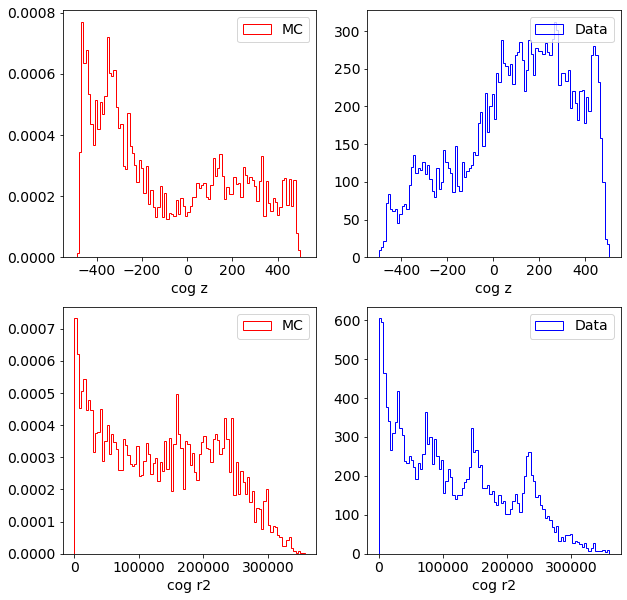

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)




MC_X = MC_postcut_2['cog_z']
Data_X = Data_postcut_2['cog_z']
ax1.hist(MC_X, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax2.hist(Data_X , bins = 100, histtype='step', color = 'b', label = 'Data');
#ax1.set_yscale('log')
ax1.set_xlabel('cog z')
ax1.legend()
ax2.set_xlabel('cog z')
ax2.legend()

MC_X = MC_postcut_2['cog_r2']
Data_X = Data_postcut_2['cog_r2']
ax3.hist(MC_X, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax4.hist(Data_X, bins = 100, histtype='step', color = 'b', label = 'Data');
#ax2.set_yscale('log')
ax3.set_xlabel('cog r2')
ax3.legend()
ax4.set_xlabel('cog r2')
ax4.legend()
#plt.savefig('Plots/BDT_feat3.png')

In [14]:

Features.T[0][:] = np.concatenate((MC_postcut_2['spMPE_ldirE'],Data_postcut_2['spMPE_ldirE']))
Features.T[1][:] = np.concatenate((MC_postcut_2['spMPE_ndirE'],Data_postcut_2['spMPE_ndirE']))
Features.T[2][:] = np.concatenate((MC_postcut_2['spMPE_rlogl'],Data_postcut_2['spMPE_rlogl']))
Features.T[3][:] = np.concatenate((MC_postcut_2['spMPE_parabo'],Data_postcut_2['spMPE_parabo']))
Features.T[4][:] = np.concatenate((MC_postcut_2['LineFit_delta_angle'],Data_postcut_2['LineFit_delta_angle']))
Features.T[5][:] = np.concatenate((MC_postcut_2['MPEHighNoise_delta_angle'],Data_postcut_2['MPEHighNoise_delta_angle']))
Features.T[6][:] = np.concatenate((MC_postcut_2['SplitMinZenith'],Data_postcut_2['SplitMinZenith']))
Features.T[7][:] = np.concatenate((MC_postcut_2['BayesLLHRatio'],Data_postcut_2['BayesLLHRatio']))
Features.T[8][:] = np.concatenate((MC_postcut_2['cog_z'],Data_postcut_2['cog_z']))
Features.T[9][:] = np.concatenate((MC_postcut_2['cog_r2'],Data_postcut_2['cog_r2']))

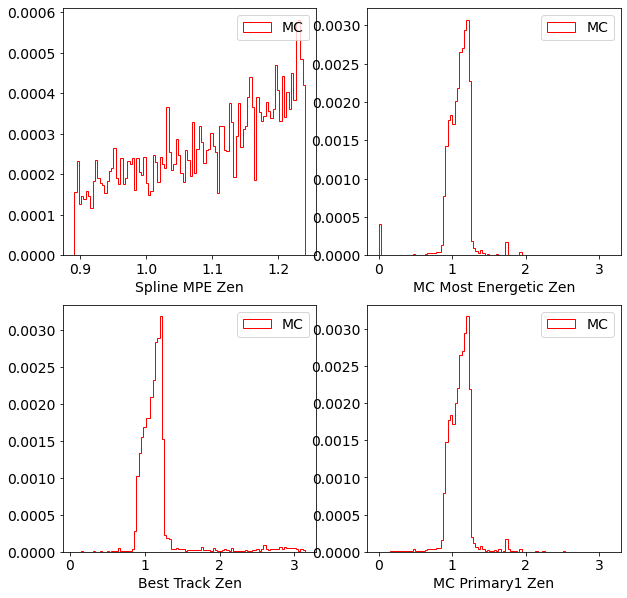

In [15]:

fig, ax = plt.subplots(figsize=(10, 10))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)




spMPE_zen = MC_postcut_2['spMPE_zenith']
ax1.hist(spMPE_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax1.set_xlabel('Spline MPE Zen')
ax1.legend()

mcMostEnergetic_zen = MC_postcut_2['mc_zenith']
ax2.hist(mcMostEnergetic_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax2.set_xlabel('MC Most Energetic Zen')
ax2.legend()

BestTrack_zen = MC_postcut_2['BestTrack_zen']
ax3.hist(BestTrack_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax3.set_xlabel('Best Track Zen')
ax3.legend()

MC_Primary1_zen = MC_postcut_2['sig_zenith']
ax4.hist(MC_Primary1_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax4.set_xlabel('MC Primary1 Zen')
ax4.legend()

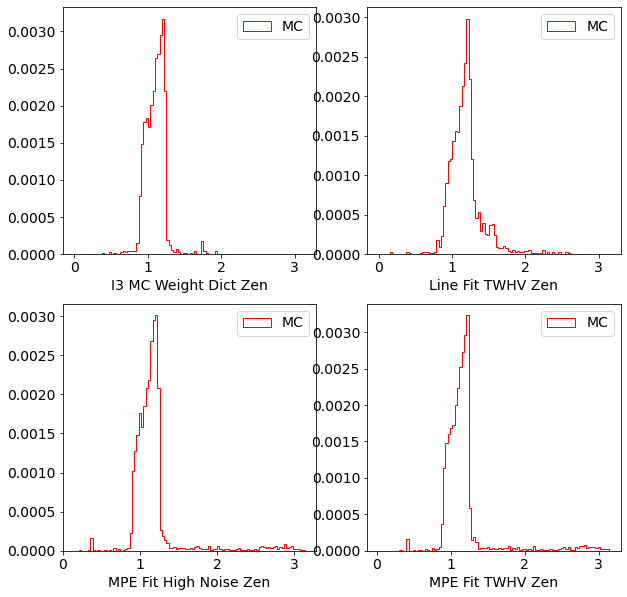

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)




I3MCWeightDict_zen = MC_postcut_2['trueZen']
ax1.hist(I3MCWeightDict_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax1.set_xlabel('I3 MC Weight Dict Zen')
ax1.legend()

LineFit_TWHV_zen = MC_postcut_2['LineFit_TWHV_zen']
ax2.hist(LineFit_TWHV_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax2.set_xlabel('Line Fit TWHV Zen')
ax2.legend()

MPEHighNoise_zen = MC_postcut_2['MPEFitHighNoise_zen']
ax3.hist(MPEHighNoise_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax3.set_xlabel('MPE Fit High Noise Zen')
ax3.legend()

MPEFit_TWHV_zen = MC_postcut_2['MPEFit_TWHV_zen']
ax4.hist(MPEFit_TWHV_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax4.set_xlabel('MPE Fit TWHV Zen')
ax4.legend()

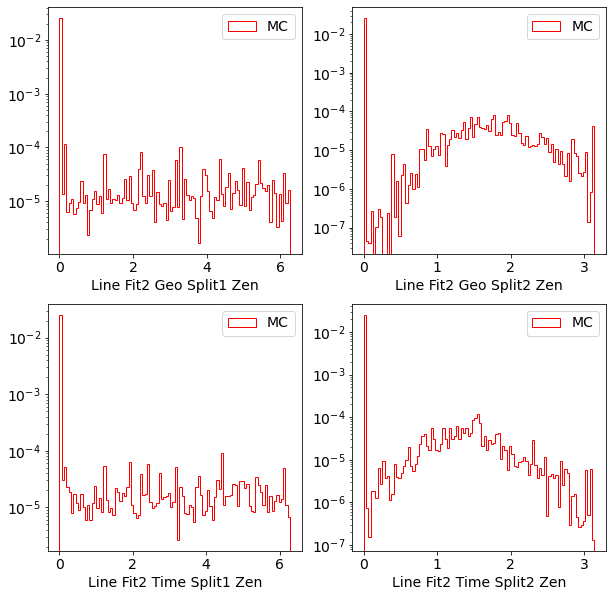

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)




LineFit2GeoSplit1_zen = MC_postcut_2['LineFit2GeoSplit1_zen']
ax1.hist(LineFit2GeoSplit1_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax1.set_xlabel('Line Fit2 Geo Split1 Zen')
ax1.set_yscale('log')
ax1.legend()

LineFit2GeoSplit2_zen = MC_postcut_2['LineFit2GeoSplit2_zen']
ax2.hist(LineFit2GeoSplit2_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax2.set_xlabel('Line Fit2 Geo Split2 Zen')
ax2.set_yscale('log')
ax2.legend()

LineFit2TimeSplit1_zen = MC_postcut_2['LineFit2TimeSplit1_zen']
ax3.hist(LineFit2TimeSplit1_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax3.set_xlabel('Line Fit2 Time Split1 Zen')
ax3.set_yscale('log')
ax3.legend()

LineFit2TimeSplit2_zen = MC_postcut_2['LineFit2TimeSplit2_zen']
ax4.hist(LineFit2TimeSplit2_zen, bins = 100, histtype='step', color = 'r', label = 'MC', weights=mcWeights_20);
ax4.set_xlabel('Line Fit2 Time Split2 Zen')
ax4.set_yscale('log')
ax4.legend()

In [18]:
print(len(MC_postcut_2))
len(Data_postcut_2)

14674


17172